# NUWE HACKATHON

In this problem we have two differents datasets to use. The most important one, the IBEX35 index. We are asked to predict if the index will raise or fall 3-days in advance. Moreover, it is believed that Twitter sentiment can help to this task. Since we do not have too much time, a sentiment analysis is discarded and adviced for a future work, see https://www.researchgate.net/publication/354308107_Stock_Market_Prediction_Using_Twitter_Sentiment_Analysis/fulltext/6130813a0360302a007377f2/Stock-Market-Prediction-Using-Twitter-Sentiment-Analysis.pdf?origin=publication_detail or https://www.scirp.org/journal/paperinformation.aspx?paperid=104142#:~:text=In%20their%20article%2C%20the%20researchers,current%20day%27s%20stock%20market%20Sentiment. 
Our strategy will consist on the hypothesis that when we are in a bull market, more twits are done, thus more volume, in order to use this feature in the IBEX35 values from 2015 until 2019. 

Let's start!

## Libraries

In [320]:
# libraries

import pandas as pd
import numpy as np
import itertools

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
import datetime
from datetime import timedelta
import collections

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, BaggingRegressor, BaggingClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from torch.utils.data import Dataset, DataLoader
import xgboost as xgb
from xgboost import plot_importance

from rfpimp import *
import os
#AE
from fastai.basics import *
from fastai.tabular.all import * 

from tsai.all import *

## Datasets

### Ibex

In [274]:
ibex_df = pd.read_csv('train.csv')

In [3]:
ibex_df.columns, ibex_df.shape

(Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
        'Target'],
       dtype='object'),
 (6554, 8))

In [4]:
ibex_df.head(3)

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1


In [5]:
ibex_df.describe()

,Open,High,Low,Close,Adj Close,Volume,Target
count,6421.000000,6421.000000,6421.000000,6421.000000,6421.000000,6.421000e+03,6554.000000
mean,8936.540448,9005.235576,8858.340567,8934.978558,8934.970624,8.218074e+07,0.516936
std,2732.102441,2749.009324,2712.511028,2731.032625,2731.030170,1.231845e+08,0.499751
min,2865.100098,2877.300049,2833.600098,2865.100098,2865.097168,0.000000e+00,0.000000
25%,7732.399902,7817.200195,7641.500000,7727.799805,7727.791992,0.000000e+00,0.000000
50%,9329.700195,9404.599609,9243.000000,9331.000000,9331.000000,1.966000e+05,1.000000
75%,10525.500000,10590.299805,10441.200195,10523.400391,10523.400391,1.773980e+08,1.000000
max,15999.200195,16040.400391,15868.599609,15945.700195,15945.683594,7.894902e+08,1.000000


In [275]:
ibex_df.isnull().sum()

Date           0
Open         133
High         133
Low          133
Close        133
Adj Close    133
Volume       133
Target         0
dtype: int64

Probably it does not make sense to mantain this rows, let's do a quick sight to them and we will likely interpolate them.

In [7]:
list(ibex_df[ibex_df.isnull().any(axis=1)]['Date'])

['1994-01-06',
 '1994-04-01',
 '1994-04-04',
 '1994-05-02',
 '1994-10-12',
 '1994-11-01',
 '1994-11-09',
 '1994-12-06',
 '1994-12-08',
 '1994-12-26',
 '1995-01-06',
 '1995-03-20',
 '1995-04-13',
 '1995-04-14',
 '1995-05-01',
 '1995-05-02',
 '1995-05-15',
 '1995-08-15',
 '1995-10-12',
 '1995-11-01',
 '1995-12-06',
 '1995-12-08',
 '1995-12-25',
 '1996-01-01',
 '1996-04-04',
 '1996-04-05',
 '1996-05-01',
 '1996-05-02',
 '1996-05-15',
 '1996-08-15',
 '1996-11-01',
 '1996-12-06',
 '1996-12-24',
 '1996-12-25',
 '1997-01-01',
 '1997-01-06',
 '1997-03-27',
 '1997-03-28',
 '1997-05-01',
 '1997-05-02',
 '1997-05-15',
 '1997-07-25',
 '1997-08-15',
 '1997-12-08',
 '1997-12-24',
 '1997-12-25',
 '1998-01-01',
 '1998-01-06',
 '1998-03-19',
 '1998-04-09',
 '1998-04-10',
 '1998-04-13',
 '1998-05-01',
 '1998-06-01',
 '1998-10-12',
 '1998-12-08',
 '1998-12-24',
 '1998-12-25',
 '1998-12-31',
 '1999-01-01',
 '1999-01-06',
 '1999-04-01',
 '1999-04-02',
 '1999-04-05',
 '1999-10-12',
 '1999-11-01',
 '1999-12-

Almost all of them are before 2005, so we are not losing an important part of our dataset. And it is normal that information were lost in that epoch!

In [8]:
ibex_df[ibex_df.isnull().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume,Target
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
64,1994-04-01,NaN,NaN,NaN,NaN,NaN,NaN,0
65,1994-04-04,NaN,NaN,NaN,NaN,NaN,NaN,0
85,1994-05-02,NaN,NaN,NaN,NaN,NaN,NaN,0
202,1994-10-12,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
3125,2005-12-26,NaN,NaN,NaN,NaN,NaN,NaN,0
3385,2007-01-01,NaN,NaN,NaN,NaN,NaN,NaN,0
3637,2007-12-24,NaN,NaN,NaN,NaN,NaN,NaN,0
4661,2012-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0


In [276]:
ibex_df.interpolate(inplace=True)

In [277]:
ibex_df.isnull().sum(), ibex_df.shape

(Date         0
 Open         0
 High         0
 Low          0
 Close        0
 Adj Close    0
 Volume       0
 Target       0
 dtype: int64,
 (6554, 8))

### Twitter IBEX35

In [11]:
twitter_df = pd.read_csv('tweets_from2015_#Ibex35.csv')

In [12]:
twitter_df.shape, twitter_df.isnull().sum()

((9801, 3),
 tweetDate    2
 handle       3
 text         4
 dtype: int64)

In [13]:
twitter_df[twitter_df.isnull().any(axis=1)]

,tweetDate,handle,text
1070,Mon Mar 08 07:13:57 +0000 2021,pharma_jonpi,NaN
6931,NaN,NaN,NaN
9634,NaN,NaN,NaN
9667,Y Montoro dando caña....,NaN,NaN


Misslabeled twits!

In [14]:
twitter_df.dropna(inplace=True)

In [15]:
twitter_df.reset_index(drop=True, inplace=True)

In [16]:
twitter_df.shape

(9797, 3)

In [17]:
twitter_df.head(3)

,tweetDate,handle,text
0,Sat Apr 09 14:47:45 +0000 2022,abelac62,"He hecho el repaso de todos los componentes del #IBEX35 y ahora me pongo con lo de La Chiqui. Si mañana tengo tiempo, publicaré algún activo interesante del mercado europeo y americano. Buen fin de semana."
1,Thu Apr 07 19:14:36 +0000 2022,LluisPerarnau,"Els projectes que han presentat les empreses del #Ibex35 als fons #NextGenerationEU: \nEndesa 110 projectes, 19.000 M €\nIberdrola 150 projectes, 21.000 M\nNaturgy 13.000 M\nACS 4.500 M\n...i així fins a sumar 100.000 M € per als grups oligàrquics de sempre."
2,Mon Apr 04 16:48:45 +0000 2022,Pegaso121080,"Por si no lo has visto, o no lo encuentras en búsquedas que suele pasar 🤔\n#Analisis y niveles del #Ibex35 y varias #Acciones en #Youtube \n#Ezentis #AedasHomes #LLeidanet #Merlinpropertis #BBVA y otras muchas en el canal 🧐\n🙏Espero que guste y/o ayude 🔄\nhttps://t.co/6yqA0TbRJY"


Before leaving this part, we should reformat the date in order to have it in the same structure as IBEX df. 

In [18]:
twitter_df['tweetDate']

0       Sat Apr 09 14:47:45 +0000 2022
1       Thu Apr 07 19:14:36 +0000 2022
2       Mon Apr 04 16:48:45 +0000 2022
3       Tue Apr 05 07:23:16 +0000 2022
4       Thu Mar 31 16:07:43 +0000 2022
                     ...              
9792    Thu Jan 08 16:41:36 +0000 2015
9793    Sat Jan 03 17:20:30 +0000 2015
9794    Sat Jan 10 19:42:45 +0000 2015
9795    Sat Jan 10 21:47:17 +0000 2015
9796    Mon Jan 05 15:06:49 +0000 2015
Name: tweetDate, Length: 9797, dtype: object

In [19]:
ibex_df['Date'][0]

'1994-01-03'

In [20]:
ex_date = twitter_df['tweetDate'][0]; ex_date, type(ex_date)

('Sat Apr 09 14:47:45 +0000 2022', str)

In [21]:
date_obj = datetime.datetime.strptime(ex_date, "%a %b %d %X %z %Y")

In [22]:
date_obj

datetime.datetime(2022, 4, 9, 14, 47, 45, tzinfo=datetime.timezone.utc)

In [23]:
new_time = date_obj.strftime("%Y-%m-%d")

In [24]:
new_time

'2022-04-09'

In [25]:
def ibex35_time(twitter_time):
    temp_time = datetime.datetime.strptime(twitter_time, "%a %b %d %X %z %Y")
    aux_time = temp_time.strftime("%Y-%m-%d")
    new_time = datetime.datetime.strptime(aux_time, "%Y-%m-%d")
    return new_time

In [26]:
non_dates_index = []
for i,row in enumerate(twitter_df.iterrows()):
    try:
        ibex35_time(row[1]['tweetDate'])
    except:
        print(row[1], i)
        twitter_df.drop(i, inplace=True)

tweetDate                        #Bolsa #IBEX35 https://t.co/2wBR9k3hHr
handle                                              Working In Progress
text         https://twitter.com/placetrading/status/961681603817852929
Name: 6930, dtype: object 6930
tweetDate                                         https://t.co/XxKoBXa3pC
handle                                                      underground73
text         https://twitter.com/underground_73/status/749536356142055424
Name: 8498, dtype: object 8498
tweetDate                                           http://t.co/c0R79uUipa
handle                                                 Verónica del Carpio
text         https://twitter.com/veronicadelcarp/status/582070485292331008
Name: 9632, dtype: object 9632
tweetDate                  http://t.co/scHVpKEQ4P http://t.co/uJaCax1Y3H
handle                                                карлос asenksiovic
text         https://twitter.com/karlitosway41/status/577538391098675200
Name: 9664, dtype: object

In [27]:
twitter_df.shape

(9793, 3)

In [28]:
twitter_df['New_Date'] = twitter_df.apply(lambda x: ibex35_time(x['tweetDate']), axis=1)

In [29]:
twitter_df.head(3)['New_Date'][0]

Timestamp('2022-04-09 00:00:00')

## EDA

### Twitter 

In order to use Twitter dataset, as it has been explained above, we will explore the correlation between twits and price. Then, it can make sense to create another variable related to different thresholds, to give more info to our final model.

In [30]:
os.makedirs(os.path.dirname('images/'), exist_ok=True)

In [31]:
count_df = pd.DataFrame(twitter_df.groupby(['New_Date'])['text'].count()); count_df

,text
New_Date,
2015-01-03,1
2015-01-04,1
2015-01-05,5
2015-01-06,3
2015-01-07,1
...,...
2022-04-05,2
2022-04-06,1
2022-04-07,4


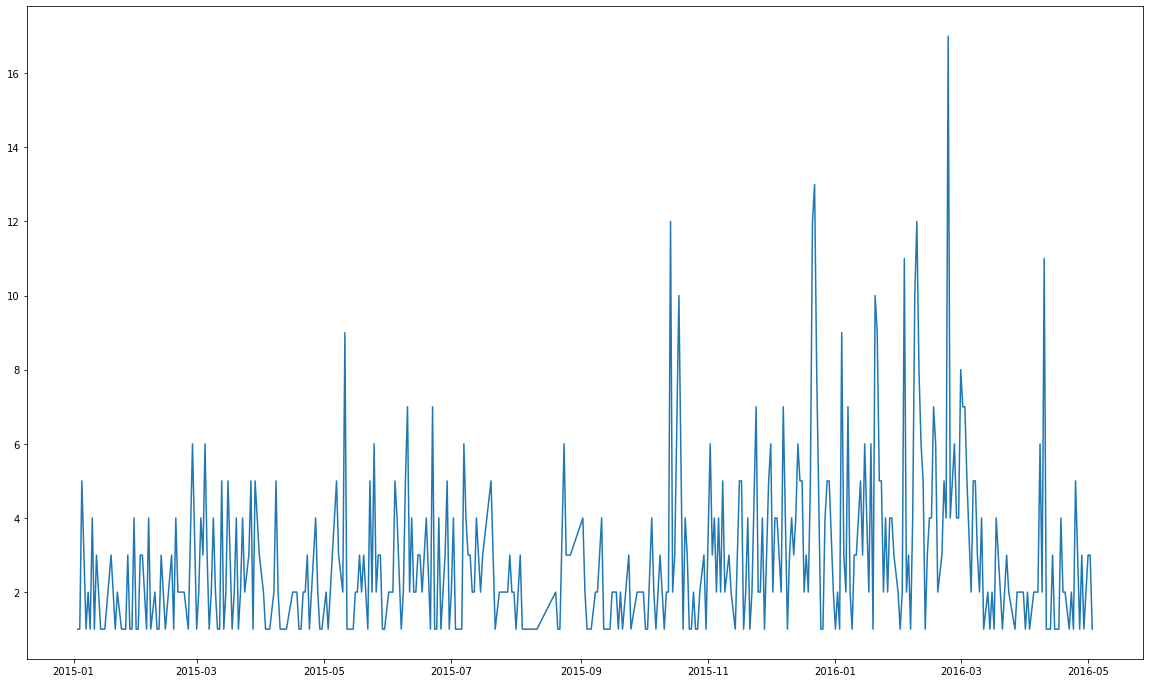

In [32]:
plt.figure(figsize = (20,12))
plt.plot(count_df.index[0:400], count_df.text[0:400])
plt.show()


### IBEX

In [114]:
ibex_df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.0,3654.5,3654.496338,0.0,0


In [34]:
c_ibex_df = ibex_df; c_ibex_df.head(2)['Date']

0    1994-01-03
1    1994-01-04
Name: Date, dtype: object

In [35]:
ibex_df.loc[2,'Date']

'1994-01-05'

In [278]:
for i,row in ibex_df.iterrows():
    ibex_df.loc[i, 'Date'] = datetime.datetime.strptime(row['Date'], "%Y-%m-%d")

In [279]:
ibex_df.head(1)

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03 00:00:00,3615.199951,3654.699951,3581.0,3654.5,3654.496338,0.0,0


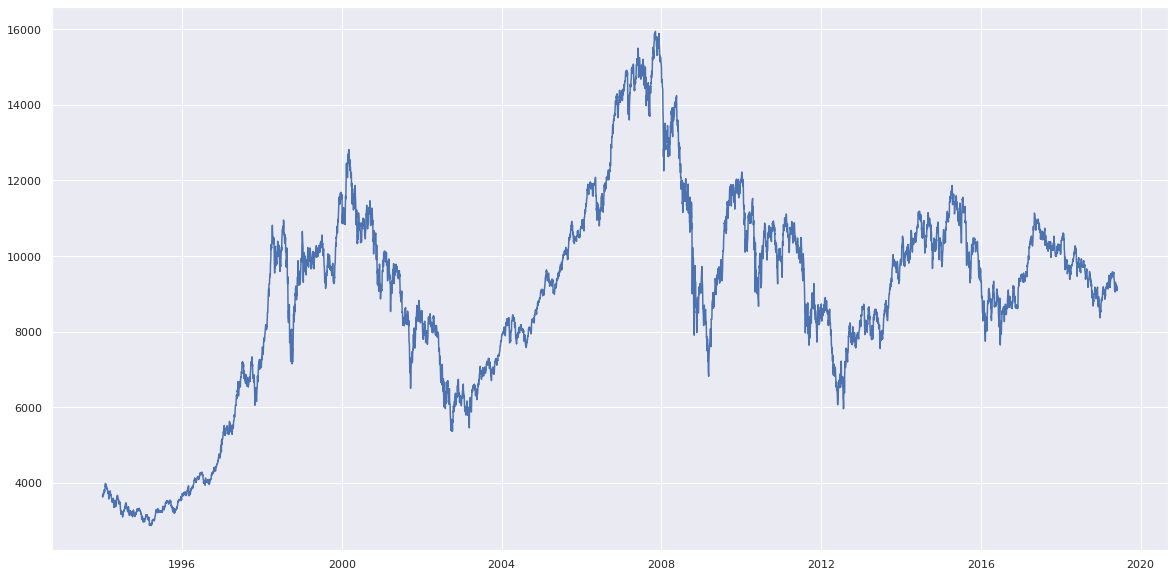

In [56]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(ibex_df.Date, ibex_df.Close)
plt.show()

In [39]:
type(ibex_df)

pandas.core.frame.DataFrame

In [280]:
# Seasonal Plot
ibex_df['Month'] = ibex_df['Date'].apply(lambda row: row.month)
ibex_df['Year'] = ibex_df['Date'].apply(lambda row: row.year)
ibex_df['Day'] = ibex_df['Date'].apply(lambda row: row.day)

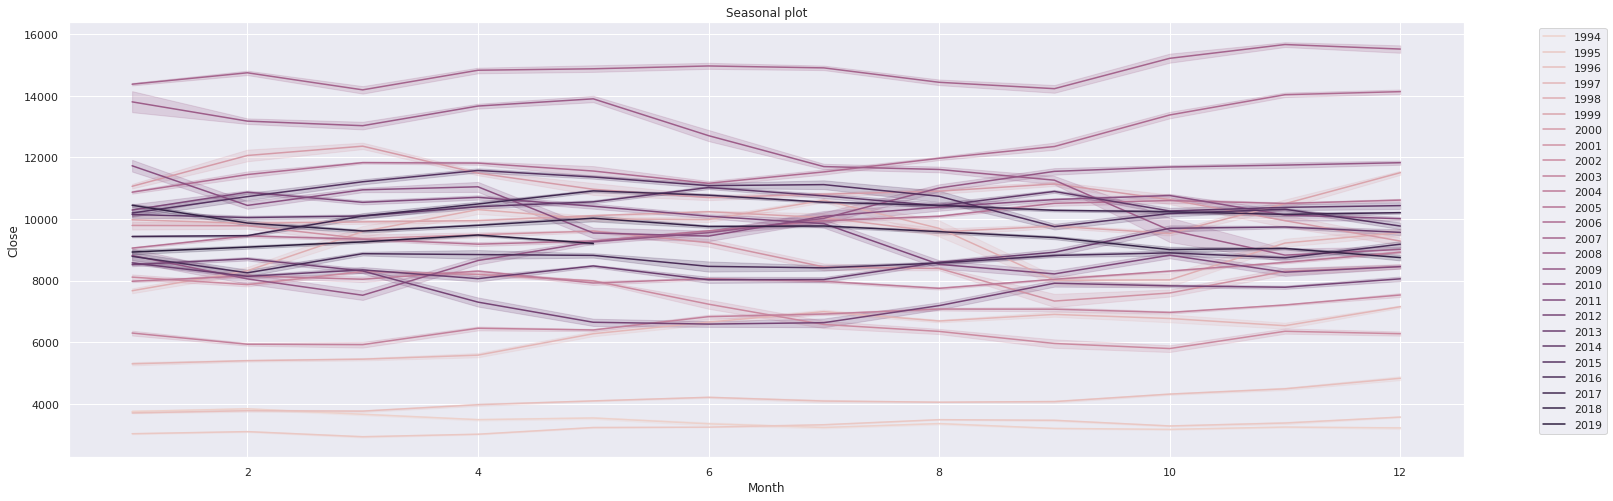

In [47]:
sns.set(rc = {'figure.figsize':(25,8)})
sns.lineplot(data=ibex_df, 
             x='Month', 
             y='Close', 
             hue='Year', 
             legend='full')

# add title
plt.title('Seasonal plot')
# move the legend outside of the main figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2);

In [52]:
# Autocorrelation Plots

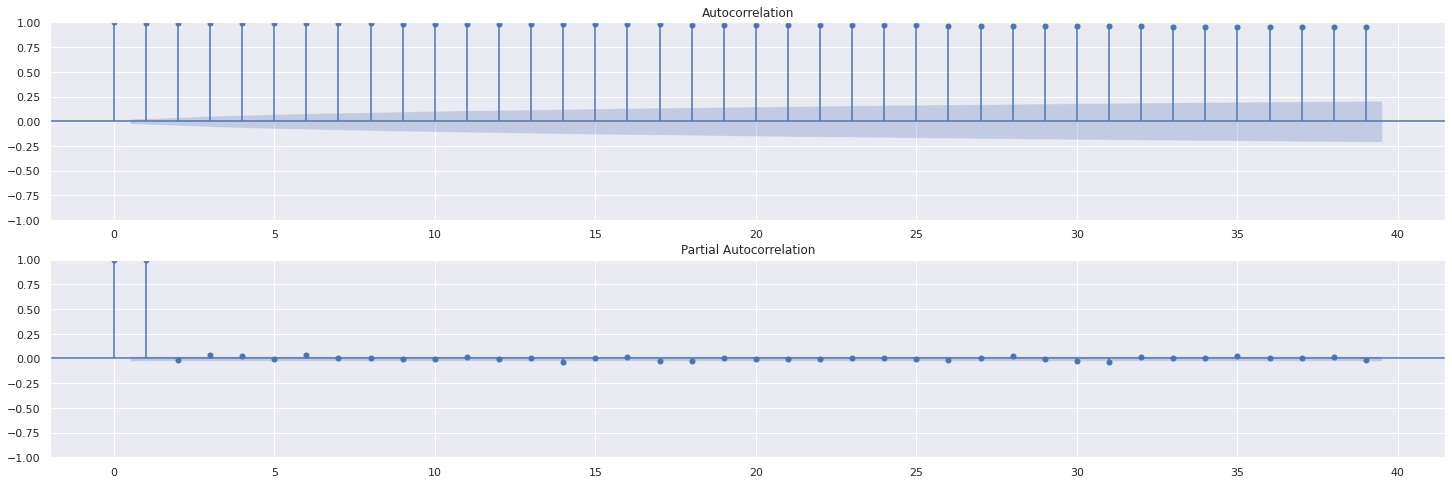

In [55]:
fig, ax = plt.subplots(2)
plot_acf(ibex_df['Adj Close'], ax=ax[0])
plot_pacf(ibex_df['Adj Close'], ax=ax[1]);

The autocorrelation function (ACF) shows the value of the correlation coefficient between the series and its lagged values. The ACF considers all of the components of the time series (mentioned in the decomposition part) while finding the correlations. That is why it’s known as the complete auto-correlation plot.

In contrast, the partial autocorrelation function (PACF) looks at the correlation between the residuals (the remainder after removing the effects explained by the previous lags) and the following lag value. This way, we effectively remove the already found variations before we find the next correlation. In practice, a high partial correlation indicates that there is some information in the residual that can be modeled by the next lag. So we might consider keeping that lag as a feature in our model.

In [120]:
# SCALING
scaler = StandardScaler()
for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
    ibex_df[col] = scaler.fit_transform(ibex_df[col].values.reshape(-1,1)).flatten()

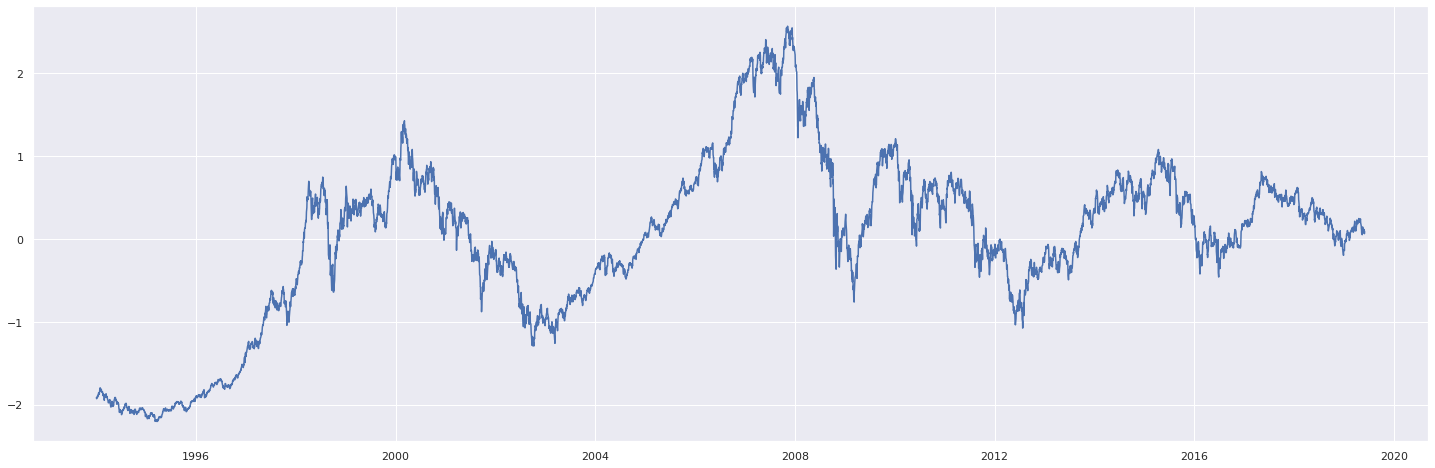

In [121]:
plt.plot(ibex_df.Date, ibex_df.Close)

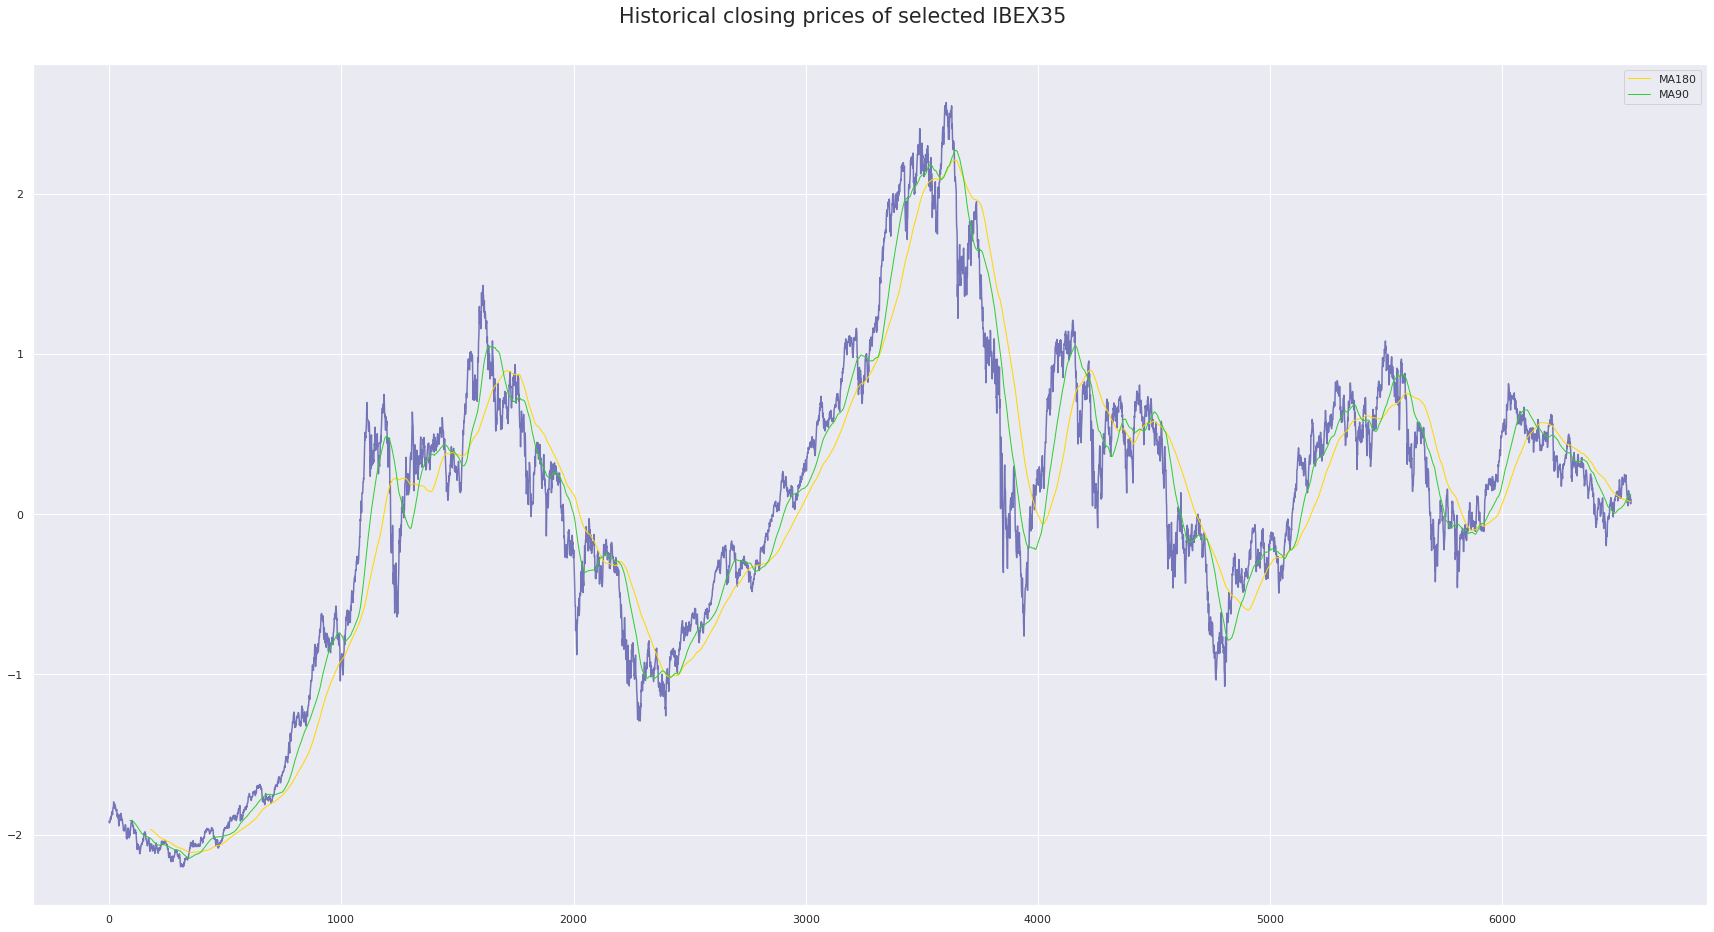

In [122]:
fig, ax = plt.subplots(figsize=(30,16))
fig.subplots_adjust(top=0.93)

ax.plot(ibex_df.index, ibex_df['Adj Close'], lw=1.5, color='navy', alpha=0.5)
ax.plot(ibex_df.index, ibex_df['Adj Close'].rolling(window=180).mean(), lw=1, color='gold', label='MA180')
ax.plot(ibex_df.index, ibex_df['Adj Close'].rolling(window=90).mean(), lw=1, color='limegreen', label='MA90')
ax.legend()
fig.suptitle('Historical closing prices of selected IBEX35', fontsize='xx-large')  
fig.autofmt_xdate(rotation=0, ha='center')
plt.show()



In [219]:
print(f"Number of times 0 is predicted: {ibex_df.loc[ibex_df['Target']==0].shape[0]}")
print(f"Number of times 1 is predicted: {ibex_df.loc[ibex_df['Target']==1].shape[0]}")

Number of times 0 is predicted: 3166
Number of times 1 is predicted: 3388


## Modeling

It should be interesting to see how it works a LSTM, XGBoost and a MiniRocket from TSAI. 

In [281]:
ibex_df.to_pickle('ibex_df.pkl')

In [760]:
ibex_df = pd.read_pickle('ibex_df.pkl')

In [761]:
ibex_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Target',
       'Month', 'Year', 'Day'],
      dtype='object')

In [562]:
def lag_with_pct_change(df, windows, col):
    train_cols = []
    df_c = df.copy()
    for window in reversed(windows):    
        df_c[f'shift_{col}_' + str(window)] = df_c[col].shift(window).fillna(0)
        train_cols.append(f'shift_{col}_' + str(window))
    return df_c, train_cols

### MiniRocket

In [762]:
ibex_df['strDate'] = ibex_df['Date'].apply(lambda row: datetime.datetime.strftime(row, "%Y-%m-%d"))

In [836]:
lag_cols = []
shifted_df,train_cols = lag_with_pct_change(ibex_df, range(1,5), 'Adj Close')
lag_cols.extend(train_cols)
shifted_df,train_cols = lag_with_pct_change(shifted_df, range(1,5), 'Volume')
lag_cols.extend(train_cols)

In [801]:
lag_cols

['shift_Adj Close_4',
 'shift_Adj Close_3',
 'shift_Adj Close_2',
 'shift_Adj Close_1',
 'shift_Volume_4',
 'shift_Volume_3',
 'shift_Volume_2',
 'shift_Volume_1']

In [802]:
shifted_df

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Month,Year,Day,strDate,shift_Adj Close_4,shift_Adj Close_3,shift_Adj Close_2,shift_Adj Close_1,shift_Volume_4,shift_Volume_3,shift_Volume_2,shift_Volume_1
0,1994-01-03 00:00:00,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,1,1994,3,1994-01-03,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
1,1994-01-04 00:00:00,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,1,1994,4,1994-01-04,0.000000,0.000000,0.000000,3654.496338,0.0,0.0,0.0,0.0
2,1994-01-05 00:00:00,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,1,1994,5,1994-01-05,0.000000,0.000000,3654.496338,3630.296387,0.0,0.0,0.0,0.0
3,1994-01-06 00:00:00,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,1,1994,6,1994-01-06,0.000000,3654.496338,3630.296387,3621.196289,0.0,0.0,0.0,0.0
4,1994-01-07 00:00:00,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,1,1994,7,1994-01-07,3654.496338,3630.296387,3621.196289,3628.796264,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6549,2019-05-24 00:00:00,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,5,2019,24,2019-05-24,9199.700195,9239.099609,9232.200195,9114.000000,153317000.0,131576400.0,146552900.0,161094300.0
6550,2019-05-27 00:00:00,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,5,2019,27,2019-05-27,9239.099609,9232.200195,9114.000000,9174.599609,131576400.0,146552900.0,161094300.0,121673100.0
6551,2019-05-28 00:00:00,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,5,2019,28,2019-05-28,9232.200195,9114.000000,9174.599609,9216.400391,146552900.0,161094300.0,121673100.0,60178000.0
6552,2019-05-29 00:00:00,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0,5,2019,29,2019-05-29,9114.000000,9174.599609,9216.400391,9191.799805,161094300.0,121673100.0,60178000.0,218900800.0


In [803]:
# New Features - Body intrinsecaly have the High-Low relationship. Close, High, Low,  can be discarded. 

In [837]:
for i,r in shifted_df.iterrows():
    shifted_df.loc[i, 'Body'] = r['High']-r['Low']

In [838]:
shifted_df

,Date,Open,High,Low,Close,Adj Close,Volume,Target,Month,Year,...,strDate,shift_Adj Close_4,shift_Adj Close_3,shift_Adj Close_2,shift_Adj Close_1,shift_Volume_4,shift_Volume_3,shift_Volume_2,shift_Volume_1,Body
0,1994-01-03 00:00:00,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,1,1994,...,1994-01-03,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,73.699951
1,1994-01-04 00:00:00,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,1,1994,...,1994-01-04,0.000000,0.000000,0.000000,3654.496338,0.0,0.0,0.0,0.0,50.399902
2,1994-01-05 00:00:00,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,1,1994,...,1994-01-05,0.000000,0.000000,3654.496338,3630.296387,0.0,0.0,0.0,0.0,41.800049
3,1994-01-06 00:00:00,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,1,1994,...,1994-01-06,0.000000,3654.496338,3630.296387,3621.196289,0.0,0.0,0.0,0.0,43.750000
4,1994-01-07 00:00:00,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,1,1994,...,1994-01-07,3654.496338,3630.296387,3621.196289,3628.796264,0.0,0.0,0.0,0.0,45.699951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6549,2019-05-24 00:00:00,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,5,2019,...,2019-05-24,9199.700195,9239.099609,9232.200195,9114.000000,153317000.0,131576400.0,146552900.0,161094300.0,69.699218
6550,2019-05-27 00:00:00,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,5,2019,...,2019-05-27,9239.099609,9232.200195,9114.000000,9174.599609,131576400.0,146552900.0,161094300.0,121673100.0,89.899414
6551,2019-05-28 00:00:00,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,5,2019,...,2019-05-28,9232.200195,9114.000000,9174.599609,9216.400391,146552900.0,161094300.0,121673100.0,60178000.0,92.000000
6552,2019-05-29 00:00:00,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0,5,2019,...,2019-05-29,9114.000000,9174.599609,9216.400391,9191.799805,161094300.0,121673100.0,60178000.0,218900800.0,81.600586


In [561]:
#train_cols

In [806]:
X = shifted_df[['Open', 'Body', 'Adj Close', 'Volume']+lag_cols]
y = shifted_df['Target']
X = X.astype(np.float32)

In [807]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [808]:
X_test

,Open,Body,Adj Close,Volume,shift_Adj Close_4,shift_Adj Close_3,shift_Adj Close_2,shift_Adj Close_1,shift_Volume_4,shift_Volume_3,shift_Volume_2,shift_Volume_1
4915,8276.599609,204.800293,8130.991699,253633200.0,8264.191406,8290.991211,8299.491211,8280.891602,437325792.0,620088192.0,82703400.0,203332608.0
4916,8111.899902,125.799805,8167.491699,105477400.0,8290.991211,8299.491211,8280.891602,8130.991699,620088192.0,82703400.0,203332608.0,253633200.0
4917,8337.900391,160.899414,8447.590820,280533408.0,8299.491211,8280.891602,8130.991699,8167.491699,82703400.0,203332608.0,253633200.0,105477400.0
4918,8375.000000,88.299805,8403.391602,182282592.0,8280.891602,8130.991699,8167.491699,8447.590820,203332608.0,253633200.0,105477400.0,280533408.0
4919,8411.700195,60.299805,8435.791016,230118592.0,8130.991699,8167.491699,8447.590820,8403.391602,253633200.0,105477400.0,280533408.0,182282592.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6549,9150.299805,69.699219,9174.599609,121673104.0,9199.700195,9239.099609,9232.200195,9114.000000,153316992.0,131576400.0,146552896.0,161094304.0
6550,9225.900391,89.899414,9216.400391,60178000.0,9239.099609,9232.200195,9114.000000,9174.599609,131576400.0,146552896.0,161094304.0,121673104.0
6551,9220.400391,92.000000,9191.799805,218900800.0,9232.200195,9114.000000,9174.599609,9216.400391,146552896.0,161094304.0,121673104.0,60178000.0
6552,9113.200195,81.600586,9080.500000,148987104.0,9114.000000,9174.599609,9216.400391,9191.799805,161094304.0,121673104.0,60178000.0,218900800.0


In [809]:
y_train, y_test

(0       0
 1       1
 2       1
 3       0
 4       1
        ..
 4910    1
 4911    1
 4912    0
 4913    0
 4914    1
 Name: Target, Length: 4915, dtype: int64,
 4915    1
 4916    1
 4917    0
 4918    1
 4919    1
        ..
 6549    0
 6550    0
 6551    0
 6552    0
 6553    0
 Name: Target, Length: 1639, dtype: int64)

MiniRocket need to have special input, sktime type data. See https://github.com/timeseriesAI/tsai/tree/main/tutorial_nbs for more info.

In [810]:
# Preparing Data for MiniRocket!

In [811]:
X_train_sktime = pd.DataFrame()
train_series_holder = []
for i in range(len(X_train)):
    series = X_train.iloc[i,:].values
    series = pd.Series(series)
    train_series_holder.append(series)
X_train_sktime["dim0"] = train_series_holder
X_train_sktime

,dim0
0,0 3615.199951 1 73.699951 2 3654.496338 3 0.000000 4 0.000000 5 0.000000 6 0.000000 7 0.000000 8 0.000000 9 0.000000 10 0.000000 11 0.000000 dtype: float32
1,0 3654.500000 1 50.399902 2 3630.296387 3 0.000000 4 0.000000 5 0.000000 6 0.000000 7 3654.496338 8 0.000000 9 0.000000 10 0.000000 11 0.000000 dtype: float32
2,0 3625.199951 1 41.800049 2 3621.196289 3 0.000000 4 0.000000 5 0.000000 6 3654.496338 7 3630.296387 8 0.000000 9 0.000000 10 0.000000 11 0.000000 dtype: float32
3,0 3623.199951 1 43.750000 2 3628.796143 3 0.000000 4 0.000000 5 3654.496338 6 3630.296387 7 3621.196289 8 0.000000 9 0.000000 10 0.000000 11 0.000000 dtype: float32
4,0 3621.199951 1 45.699951 2 3636.396240 3 0.000000 4 3654.496338 5 3630.296387 6 3621.196289 7 3628.796143 8 0.000000 9 0.000000 10 0.000000 11 0.000000 dtype: float32
...,...
4910,0 8.192300e+03 1 1.366001e+02 2 8.264191e+03 3 4.363194e+08 4 8.017092e+03 5 8.024092e+03 6 8.040292e+03 7 8.168792e+03 8 1.980520e+08 9 1.769212e+08 10 1.831250e+08 11 2.955806e+08 dtype: float32
4911,0 8.226700e+03 1 8.110059e+01 2 8.264191e+03 3 4.373258e+08 4 8.024092e+03 5 8.040292e+03 6 8.168792e+03 7 8.264191e+03 8 1.769212e+08 9 1.831250e+08 10 2.955806e+08 11 4.363194e+08 dtype: float32
4912,0 8.223500e+03 1 8.720020e+01 2 8.290991e+03 3 6.200882e+08 4 8.040292e+03 5 8.168792e+03 6 8.264191e+03 7 8.264191e+03 8 1.831250e+08 9 2.955806e+08 10 4.363194e+08 11 4.373258e+08 dtype: float32
4913,0 8.261600e+03 1 4.829980e+01 2 8.299491e+03 3 8.270340e+07 4 8.168792e+03 5 8.264191e+03 6 8.264191e+03 7 8.290991e+03 8 2.955806e+08 9 4.363194e+08 10 4.373258e+08 11 6.200882e+08 dtype: float32


In [812]:
X_test_sktime = pd.DataFrame()
test_series_holder = []
for i in range(len(X_test)):
    series = X_test.iloc[i,:].values
    series = pd.Series(series)
    test_series_holder.append(series)
X_test_sktime["dim0"] = test_series_holder
X_test_sktime

,dim0
0,0 8.276600e+03 1 2.048003e+02 2 8.130992e+03 3 2.536332e+08 4 8.264191e+03 5 8.290991e+03 6 8.299491e+03 7 8.280892e+03 8 4.373258e+08 9 6.200882e+08 10 8.270340e+07 11 2.033326e+08 dtype: float32
1,0 8.111900e+03 1 1.257998e+02 2 8.167492e+03 3 1.054774e+08 4 8.290991e+03 5 8.299491e+03 6 8.280892e+03 7 8.130992e+03 8 6.200882e+08 9 8.270340e+07 10 2.033326e+08 11 2.536332e+08 dtype: float32
2,0 8.337900e+03 1 1.608994e+02 2 8.447591e+03 3 2.805334e+08 4 8.299491e+03 5 8.280892e+03 6 8.130992e+03 7 8.167492e+03 8 8.270340e+07 9 2.033326e+08 10 2.536332e+08 11 1.054774e+08 dtype: float32
3,0 8.375000e+03 1 8.829980e+01 2 8.403392e+03 3 1.822826e+08 4 8.280892e+03 5 8.130992e+03 6 8.167492e+03 7 8.447591e+03 8 2.033326e+08 9 2.536332e+08 10 1.054774e+08 11 2.805334e+08 dtype: float32
4,0 8.411700e+03 1 6.029980e+01 2 8.435791e+03 3 2.301186e+08 4 8.130992e+03 5 8.167492e+03 6 8.447591e+03 7 8.403392e+03 8 2.536332e+08 9 1.054774e+08 10 2.805334e+08 11 1.822826e+08 dtype: float32
...,...
1634,0 9.150300e+03 1 6.969922e+01 2 9.174600e+03 3 1.216731e+08 4 9.199700e+03 5 9.239100e+03 6 9.232200e+03 7 9.114000e+03 8 1.533170e+08 9 1.315764e+08 10 1.465529e+08 11 1.610943e+08 dtype: float32
1635,0 9.225900e+03 1 8.989941e+01 2 9.216400e+03 3 6.017800e+07 4 9.239100e+03 5 9.232200e+03 6 9.114000e+03 7 9.174600e+03 8 1.315764e+08 9 1.465529e+08 10 1.610943e+08 11 1.216731e+08 dtype: float32
1636,0 9.220400e+03 1 9.200000e+01 2 9.191800e+03 3 2.189008e+08 4 9.232200e+03 5 9.114000e+03 6 9.174600e+03 7 9.216400e+03 8 1.465529e+08 9 1.610943e+08 10 1.216731e+08 11 6.017800e+07 dtype: float32
1637,0 9.113200e+03 1 8.160059e+01 2 9.080500e+03 3 1.489871e+08 4 9.114000e+03 5 9.174600e+03 6 9.216400e+03 7 9.191800e+03 8 1.610943e+08 9 1.216731e+08 10 6.017800e+07 11 2.189008e+08 dtype: float32


In [813]:
X_train_sktime.shape, y_train.shape

((4915, 1), (4915,))

In [814]:
X_test_sktime.shape, y_test.shape

((1639, 1), (1639,))

In [815]:
# Computes MiniRocket features using the original (non-PyTorch) MiniRocket code.
# It then sends them to a sklearn's RidgeClassifier (linear classifier).
model = MiniRocketClassifier()
timer.start(False)
model.fit(X_train_sktime, y_train)
t = timer.stop()

In [533]:
print(f'valid accuracy    : {model.score(X_test_sktime, y_test):.3%} time: {t}')

valid accuracy    : 50.850% time: 0:00:53.859729


In [816]:
y_pred = model.predict(X_test_sktime)
print(f'F1 Score {f1_score(y_test, y_pred, average="macro")}')

F1 Score 0.4859651873921907


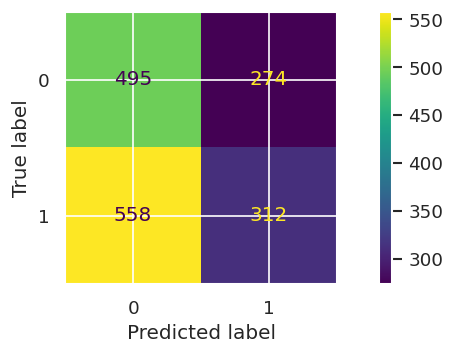

In [839]:
ConfusionMatrixDisplay.from_estimator(model, X_test_sktime, y_test)

In [818]:
def minirocket(df):
    X_train_sktime = pd.DataFrame()
    train_series_holder = []
    for i in range(len(X_train)):
        series = X_train.iloc[i,:].values
        series = pd.Series(series)
        train_series_holder.append(series)
    X_train_sktime["dim0"] = train_series_holder
    X_test_sktime = pd.DataFrame()
    test_series_holder = []
    for i in range(len(X_test)):
        series = X_test.iloc[i,:].values
        series = pd.Series(series)
        test_series_holder.append(series)
    X_test_sktime["dim0"] = test_series_holder
    model = MiniRocketClassifier()
    model.fit(X_train_sktime, y_train)
    y_pred = model.predict(X_test_sktime)
    print(f'F1 Score {f1_score(y_test, y_pred, average="macro")}')
    
    return model

In [840]:
shifted_df.drop(lag_cols, axis=1, inplace=True)

In [841]:
shifted_df.set_index('Date')

,Open,High,Low,Close,Adj Close,Volume,Target,Month,Year,Day,strDate,Body
Date,,,,,,,,,,,,
1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0,1,1994,3,1994-01-03,73.699951
1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1,1,1994,4,1994-01-04,50.399902
1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1,1,1994,5,1994-01-05,41.800049
1994-01-06,3623.199951,3634.799926,3591.049926,3628.799926,3628.796264,0.0,0,1,1994,6,1994-01-06,43.750000
1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1,1,1994,7,1994-01-07,45.699951
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0,5,2019,24,2019-05-24,69.699218
2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0,5,2019,27,2019-05-27,89.899414
2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0,5,2019,28,2019-05-28,92.000000


In [842]:
lag_cols = []
shifted_df, train_cols = lag_with_pct_change(shifted_df, range(1,14), 'Adj Close')
lag_cols.extend(train_cols)
shifted_df, train_cols = lag_with_pct_change(shifted_df, range(1,3),'Volume')
lag_cols.extend(train_cols)

In [843]:
minirocket(shifted_df[['Open', 'Body', 'Adj Close', 'Volume']+lag_cols])

F1 Score 0.49350688457306835


Pipeline(steps=[('minirocketmultivariate', MiniRocketMultivariate()), ('ridgeclassifiercv', RidgeClassifierCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                  normalize=True))])

### Naives Bayes

In [207]:
from sklearn.naive_bayes import GaussianNB

In [369]:
nb_df = ibex_df
# SCALING
scaler = MinMaxScaler()
for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
    nb_df[col] = scaler.fit_transform(nb_df[col].values.reshape(-1,1)).flatten()

In [373]:
nb_shifted_df, cols = lag_with_pct_change(nb_df, range(1,10))

In [374]:
nb_shifted_df = nb_shifted_df[len(cols):]

In [375]:
X = shifted_df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']+cols]
y = shifted_df['Target']

In [376]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [377]:
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_valid)

In [378]:
print("Number of mislabeled points out of a total %d points : %d"% (X_valid.shape[0], (y_valid != y_pred).sum()))

Number of mislabeled points out of a total 1639 points : 877


In [379]:
f1_score(y_valid, y_pred)

0.31430805316653637

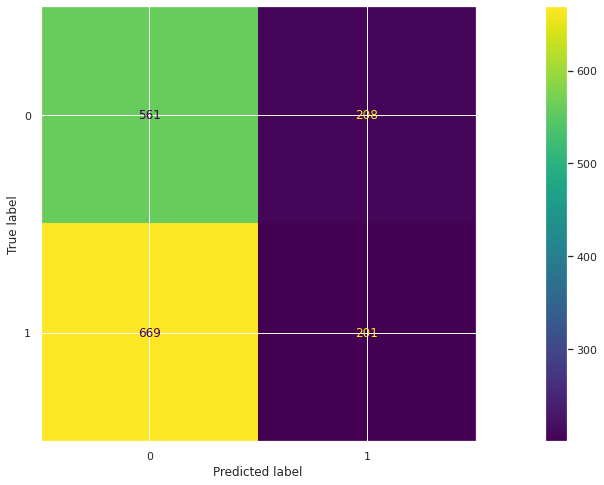

In [380]:
ConfusionMatrixDisplay.from_estimator(gnb, X_valid , y_valid)

### XGBoost 

In [381]:
xgbr = xgb.XGBClassifier(objective='binary:logistic')
xgbr.fit(X_train, y_train)
 
ypred = xgbr.predict(X_valid)
print(f1_score(y_valid, ypred, average='macro'))

0.5090028132492822


In [382]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [200],
           'colsample_bytree': [0.3, 0.7]}
xgbr = xgb.XGBClassifier(seed = 42)
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='f1_macro', 
                   verbose=1)
clf.fit(X, y)
print("Best parameters:", clf.best_params_)
print("Best F!: ", (clf.best_score_))

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 200}
Best F!:  0.4732953869712572


In [236]:
xgbr = xgb.XGBClassifier(learning_rate=0.05, n_estimators=200, colsample_bytree=0.7, max_depth=6, objective='binary:logistic', seed=42)
xgbr.fit(X_train, y_train)
 
ypred = xgbr.predict(X_valid)
print(f1_score(y_valid, ypred, average='macro'))

0.49114505130130126


### Random Forest

#### Without Lag 

In [439]:
dt_df = ibex_df

In [440]:
dt_df.set_index('Date', inplace=True)

In [442]:
dt_df.drop(['Month', 'Year', 'Day'], axis=1, inplace=True)

In [443]:
X = dt_df[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
y = dt_df['Target']

In [445]:
scaler = MinMaxScaler()
for col in ['Open', 'High', 'Low', 'Adj Close', 'Volume']:
    dt_df[col] = scaler.fit_transform(dt_df[col].values.reshape(-1,1)).flatten()

In [446]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [447]:
clf = RandomForestClassifier()

In [448]:
clf.fit(X_train, y_train)

RandomForestClassifier()

In [449]:
y_pred = clf.predict(X_test)

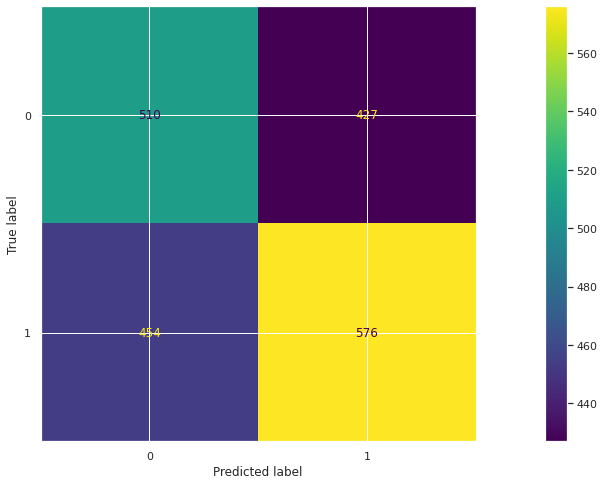

In [450]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

In [451]:
print(f'F1 Score {f1_score(y_test, y_pred, average="macro")}')

F1 Score 0.5516049879771773


In [461]:
param_grid = { 
    'n_estimators': [200,500],
    'max_depth' : [7,8,9,10,12],
}

In [462]:
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [7, 8, 9, 10, 12],
                         'n_estimators': [200, 500]})

In [416]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 200}

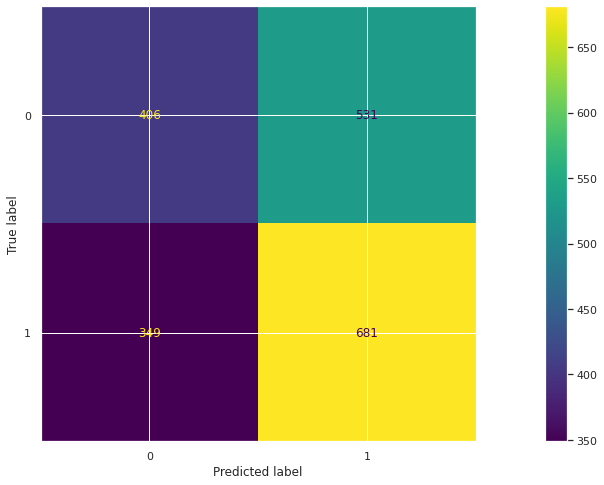

In [463]:
ConfusionMatrixDisplay.from_estimator(CV_rfc, X_test, y_test)

In [464]:
print(f'F1 Score {f1_score(y_test, CV_rfc.predict(X_test), average="macro")}')

F1 Score 0.5436993734486475


In [456]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 300, max_depth=10, criterion='gini')

In [457]:
rfc1.fit(X_train, y_train)
rfc_pred=rfc1.predict(X_test)

In [458]:
print(f'F1 Score {f1_score(y_test, rfc_pred, average="macro")}')

F1 Score 0.5564825253664036


In [455]:
rfc1.feature_importances_, X_train.columns

(array([0.20487117, 0.21954953, 0.20845348, 0.19977141, 0.16735441]),
 Index(['Open', 'High', 'Low', 'Adj Close', 'Volume'], dtype='object'))

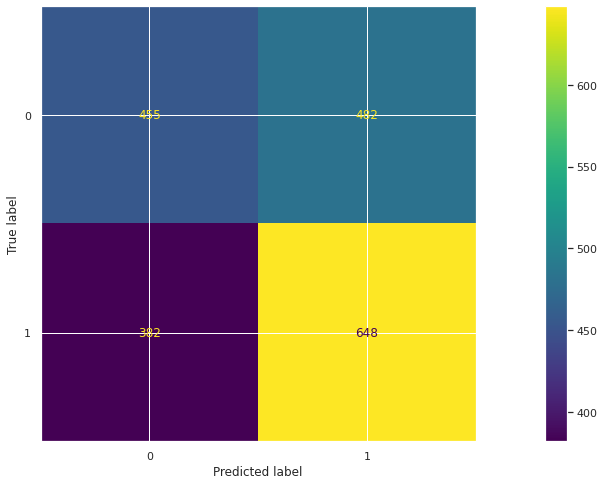

In [460]:
ConfusionMatrixDisplay.from_estimator(rfc1, X_test, y_test)

#### LAG features

In [471]:
scaler = MinMaxScaler()
for col in ['Open', 'High', 'Low', 'Adj Close', 'Volume']:
    dt_df[col] = scaler.fit_transform(dt_df[col].values.reshape(-1,1)).flatten()

In [472]:
shifted_rf_df, rf_cols = lag_with_pct_change(ibex_df, range(1,20))

In [473]:
X = shifted_rf_df[['Open', 'High', 'Low', 'Adj Close', 'Volume']+rf_cols]
y = shifted_rf_df['Target']

In [474]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [476]:
rfc1=RandomForestClassifier(random_state=42, max_features='auto', n_estimators= 300, max_depth=10, criterion='gini')

In [477]:
rfc1.fit(X_train, y_train)
rfc_pred=rfc1.predict(X_test)

In [478]:
print(f'F1 Score {f1_score(y_test, rfc_pred, average="macro")}')

F1 Score 0.5833208685808833


In [479]:
rfc1.feature_importances_, X_train.columns

(array([0.03812438, 0.04313779, 0.04141068, 0.0399647 , 0.04336814,
        0.04603483, 0.04482759, 0.04349363, 0.04247327, 0.04285228,
        0.04220971, 0.04288771, 0.03948317, 0.04391922, 0.04621524,
        0.03777059, 0.03904925, 0.03996884, 0.04011435, 0.04290246,
        0.03846305, 0.04277318, 0.03775084, 0.04080509]),
 Index(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'shift_pos_19',
        'shift_pos_18', 'shift_pos_17', 'shift_pos_16', 'shift_pos_15',
        'shift_pos_14', 'shift_pos_13', 'shift_pos_12', 'shift_pos_11',
        'shift_pos_10', 'shift_pos_9', 'shift_pos_8', 'shift_pos_7',
        'shift_pos_6', 'shift_pos_5', 'shift_pos_4', 'shift_pos_3',
        'shift_pos_2', 'shift_pos_1'],
       dtype='object'))

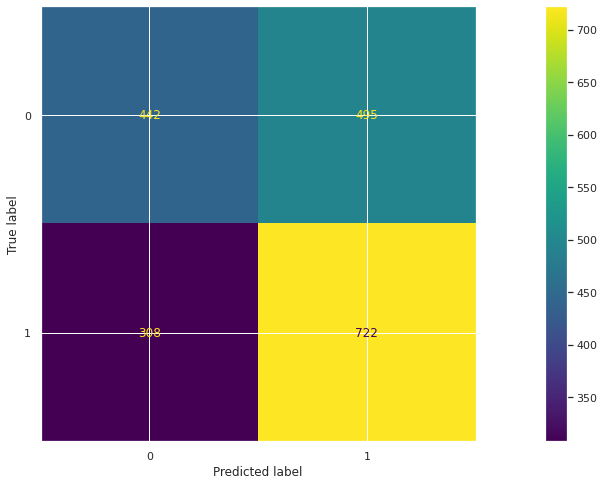

In [480]:
ConfusionMatrixDisplay.from_estimator(rfc1, X_test, y_test)

### XGBRF

#### Without LAG

In [406]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

In [407]:
PARAMETERS = {"subsample":[0.5, 0.75],
              "colsample_bytree":[0.5, 0.75],
              "max_depth":[6, 12],
              "min_child_weight":[5,15],
              "learning_rate":[0.1, 0.03],
              "n_estimators":[100]}

In [408]:
model = xgb.XGBRFClassifier(n_estimators=100, n_jobs=-1)

In [409]:
model_gs = GridSearchCV(model,param_grid=PARAMETERS,cv=3,scoring="f1_macro")
model_gs.fit(X_train,y_train)

GridSearchCV(cv=3,
             estimator=XGBRFClassifier(base_score=None, booster=None,
                                       callbacks=None, colsample_bylevel=None,
                                       colsample_bytree=None,
                                       early_stopping_rounds=None,
                                       enable_categorical=False,
                                       eval_metric=None, gamma=None,
                                       gpu_id=None, grow_policy=None,
                                       importance_type=None,
                                       interaction_constraints=None,
                                       max_bin=None, max_cat_to_onehot=None,
                                       max_delta_step=None, ma...
                                       n_estimators=100, n_jobs=-1,
                                       num_parallel_tree=None,
                                       objective='binary:logistic',
                           

In [481]:
model_gs.best_params_

{'colsample_bytree': 0.75,
 'learning_rate': 0.1,
 'max_depth': 12,
 'min_child_weight': 5,
 'n_estimators': 100,
 'subsample': 0.75}

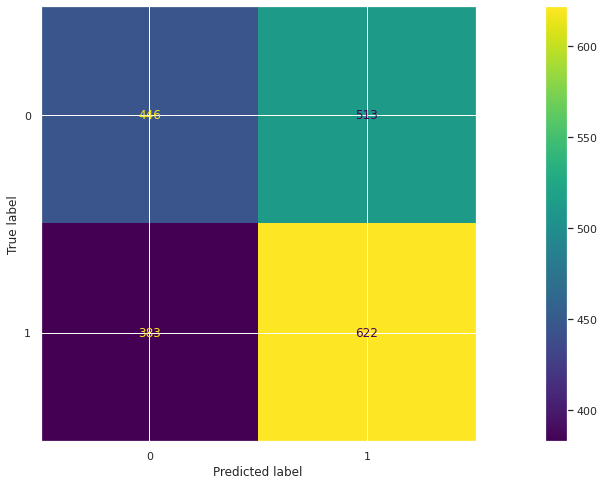

In [411]:
ConfusionMatrixDisplay.from_estimator(model_gs, X_test, y_test)

In [413]:
print(f'F1 Score {f1_score(y_test, model_gs.predict(X_test), average="macro")}')

F1 Score 0.5400949214911455


#### LAG 200

In [563]:
shifted_rf_df, rf_cols = lag_with_pct_change(ibex_df, range(1,200), 'Adj Close')

In [564]:
X = shifted_rf_df[['Open', 'High', 'Low', 'Adj Close', 'Volume']+rf_cols]
y = shifted_rf_df['Target']

In [565]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

In [566]:
model = xgb.XGBRFClassifier(n_estimators=200, max_depth=12, n_jobs=-1,)

In [567]:
print(f'F1 Score {f1_score(y_test, model.fit(X_train, y_train).predict(X_test), average="macro")}')

F1 Score 0.6345294272895223


In [501]:
model.feature_importances_

array([0.00134305, 0.00242017, 0.00350596, 0.00352846, 0.00328836,
       0.00298414, 0.00361329, 0.00330277, 0.00345455, 0.00457987,
       0.00463904, 0.00443889, 0.00576739, 0.00592902, 0.00377557,
       0.0037445 , 0.00483555, 0.00477887, 0.0039505 , 0.0046359 ,
       0.00486641, 0.00458094, 0.00402447, 0.00445281, 0.00445017,
       0.00652793, 0.00487043, 0.0042714 , 0.00386039, 0.00453988,
       0.00414503, 0.00395198, 0.00428005, 0.00398075, 0.00535446,
       0.00499067, 0.00410771, 0.00406642, 0.00461094, 0.00460849,
       0.00456912, 0.0046164 , 0.00400464, 0.00525299, 0.00463714,
       0.00544382, 0.00505854, 0.00472187, 0.00484662, 0.00414302,
       0.00495058, 0.00419923, 0.00477256, 0.00460784, 0.00500028,
       0.00433255, 0.004976  , 0.00444761, 0.00461633, 0.00446017,
       0.00468563, 0.00513399, 0.00559489, 0.0046069 , 0.00481096,
       0.00449241, 0.00425709, 0.0044847 , 0.00570671, 0.00805738,
       0.00477376, 0.00470251, 0.0061366 , 0.00547234, 0.00556

In [503]:
from sklearn.inspection import permutation_importance

Text(0.5, 0, 'Permutation Importance')

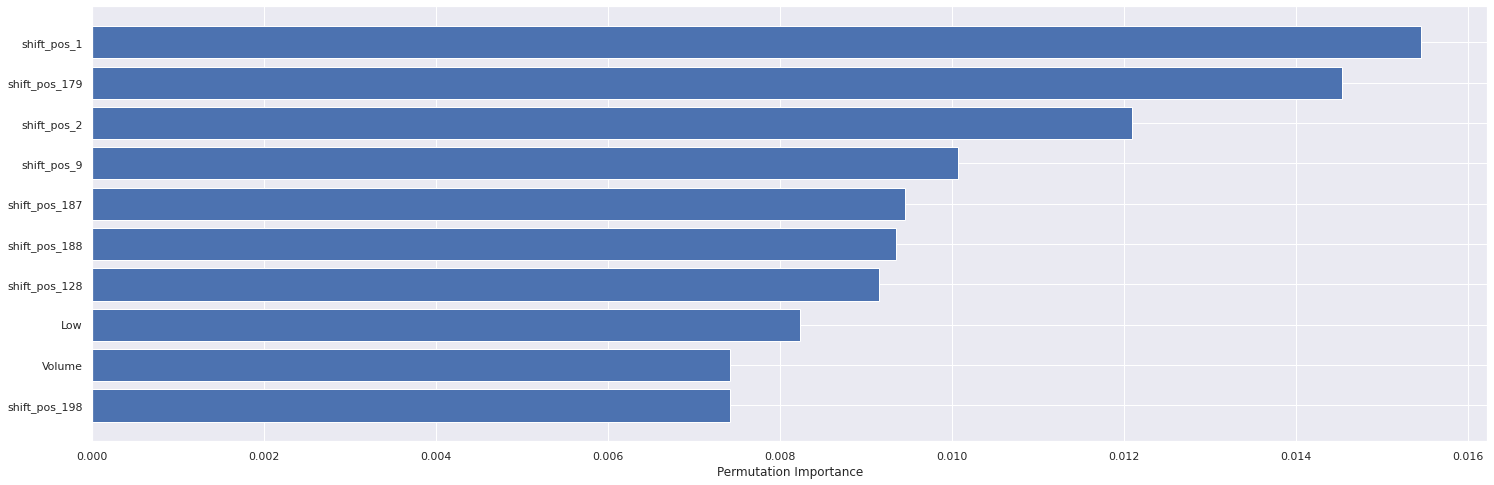

In [507]:
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx][-10:], perm_importance.importances_mean[sorted_idx][-10:])
plt.xlabel("Permutation Importance")


So far so good! It seems XGBoost is the best classifier right now. It can also be useful lagging Volume information, maybe not the same lag as the Close. At the same time, I guess Open is not very useful. 

In [688]:
xgb_mult_lag_df = ibex_df
scaler = MinMaxScaler()
for col in ['Open', 'High', 'Low', 'Adj Close', 'Volume']:
    xgb_mult_lag_df[col] = scaler.fit_transform(xgb_mult_lag_df[col].values.reshape(-1,1)).flatten()

In [703]:
lag_cols = []
xgb_mult_lag_df, xgb_mult_cols  = lag_with_pct_change(xgb_mult_lag_df, range(1,7), 'Adj Close')
lag_cols.extend(xgb_mult_cols)
xgb_mult_lag_df, xgb_mult_cols = lag_with_pct_change(xgb_mult_lag_df, range(1,7), 'Volume')
lag_cols.extend(xgb_mult_cols)

In [704]:
lag_cols[:2], lag_cols[-2:]

(['shift_Adj Close_6', 'shift_Adj Close_5'],
 ['shift_Volume_2', 'shift_Volume_1'])

In [705]:
X = xgb_mult_lag_df[['Open', 'High', 'Low', 'Adj Close', 'Volume']+lag_cols]
y = xgb_mult_lag_df['Target']

In [706]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,shuffle=False)

In [707]:
model = xgb.XGBRFClassifier(n_estimators=200, max_depth=15, n_jobs=-1, eval_metric='auc')

In [708]:
print(f'F1 Score {f1_score(y_test, model.fit(X_train, y_train).predict(X_test), average="macro")}')

F1 Score 0.49107222658838395


Text(0.5, 0, 'Permutation Importance')

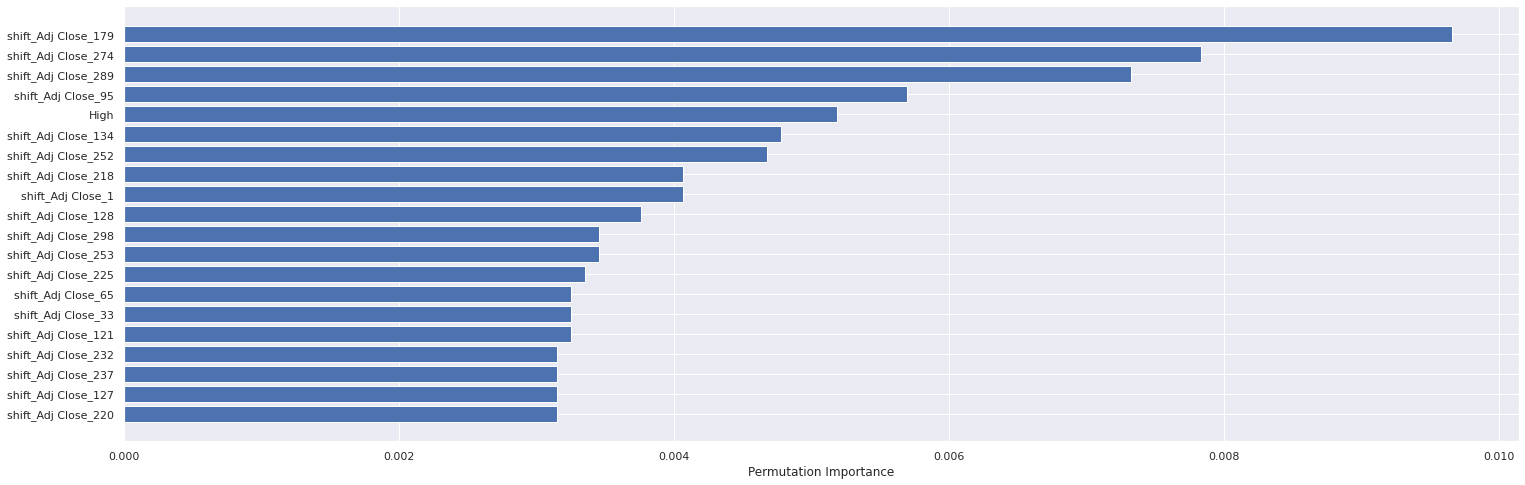

In [661]:
perm_importance = permutation_importance(model, X_test, y_test)
sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(X_train.columns[sorted_idx][-20:], perm_importance.importances_mean[sorted_idx][-20:])
plt.xlabel("Permutation Importance")

Logically, Adj Close, volume, High and Low are in the top features. It is somehow strange how far closings have this kind of importance. What we are seeing is that widening the close window give us each time better results.

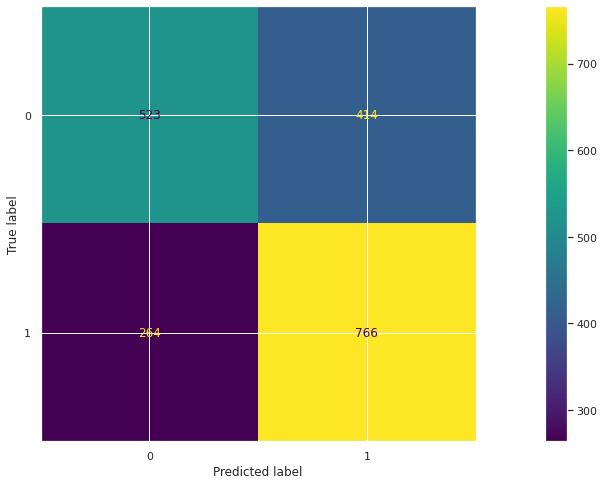

In [663]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)

### ARIMA

In [745]:
from statsmodels.tsa.arima_model import ARIMA
#!pip install pmdarima
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from numpy import log
from pmdarima.arima.utils import ndiffs

In [724]:
arima_df = ibex_df[['Date','Open', 'High', 'Low', 'Adj Close', 'Volume', 'Target']]; arima_df.set_index('Date', inplace=True)

In [725]:
arima_df

,Open,High,Low,Adj Close,Volume,Target
Date,,,,,,
1994-01-03,0.057111,0.059059,0.057338,0.060349,0.000000,0
1994-01-04,0.060103,0.060639,0.060721,0.058499,0.000000,1
1994-01-05,0.057872,0.056818,0.057522,0.057803,0.000000,1
1994-01-06,0.057720,0.057547,0.058109,0.058384,0.000000,0
1994-01-07,0.057568,0.058277,0.058696,0.058965,0.000000,1
...,...,...,...,...,...,...
2019-05-24,0.478541,0.481178,0.483913,0.482356,0.154116,0
2019-05-27,0.484297,0.487522,0.488769,0.485552,0.076224,0
2019-05-28,0.483878,0.482227,0.483260,0.483671,0.277269,0


In [726]:
result = adfuller(arima_df['Adj Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.316440
p-value: 0.166721


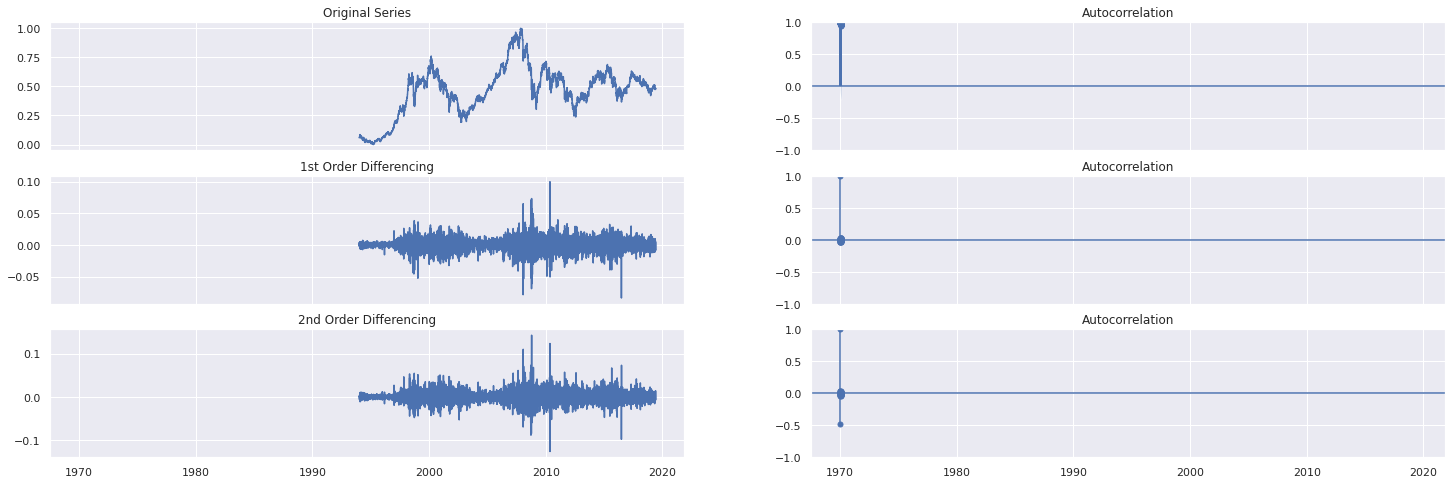

In [727]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(arima_df['Adj Close']); axes[0, 0].set_title('Original Series')
plot_acf(arima_df['Adj Close'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(arima_df['Adj Close'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(arima_df['Adj Close'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(arima_df['Adj Close'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(arima_df['Adj Close'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [730]:
y = arima_df['Target']

## Adf Test
ndiffs(y, test='adf')  # 2

# KPSS test
ndiffs(y, test='kpss')  # 0

# PP test:
ndiffs(y, test='pp')  # 2

0

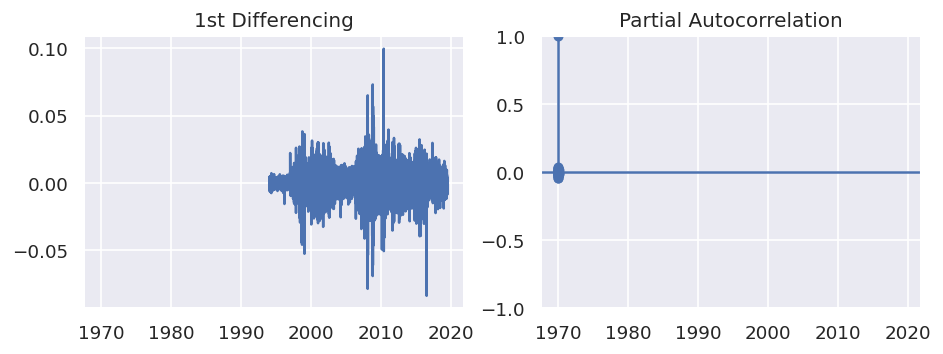

In [731]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(arima_df['Adj Close'].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(arima_df['Adj Close'].diff().dropna(), ax=axes[1])

plt.show()

In [750]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(arima_df['Adj Close'], order=(1,1,2))
model_fit = model.fit()
print(model_fit.summary())

/home/ubuntu/anaconda3/envs/rubix/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/ubuntu/anaconda3/envs/rubix/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/ubuntu/anaconda3/envs/rubix/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



                               SARIMAX Results                                
Dep. Variable:              Adj Close   No. Observations:                 6554
Model:                 ARIMA(1, 1, 2)   Log Likelihood               21080.566
Date:                Sat, 28 May 2022   AIC                         -42153.132
Time:                        18:19:11   BIC                         -42125.981
Sample:                             0   HQIC                        -42143.745
                               - 6554                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3701      0.140      2.643      0.008       0.096       0.644
ma.L1         -0.3616      0.139     -2.604      0.009      -0.634      -0.089
ma.L2         -0.0477      0.008     -5.918      0.0

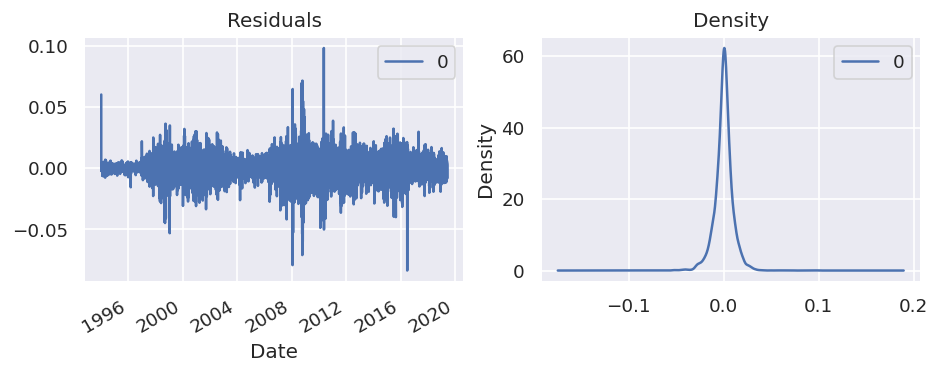

In [742]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [747]:
X = arima_df[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
y = arima_df['Target']

In [748]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,shuffle=False)

In [754]:
fc

4915    0.413903
4916    0.413808
4917    0.413738
4918    0.413687
4919    0.413650
4920    0.413623
4921    0.413603
4922    0.413588
4923    0.413577
4924    0.413569
4925    0.413564
4926    0.413559
4927    0.413556
4928    0.413554
4929    0.413552
Name: predicted_mean, dtype: float64

/home/ubuntu/anaconda3/envs/rubix/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/ubuntu/anaconda3/envs/rubix/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/ubuntu/anaconda3/envs/rubix/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/home/ubuntu/anaconda3/envs/rubix/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



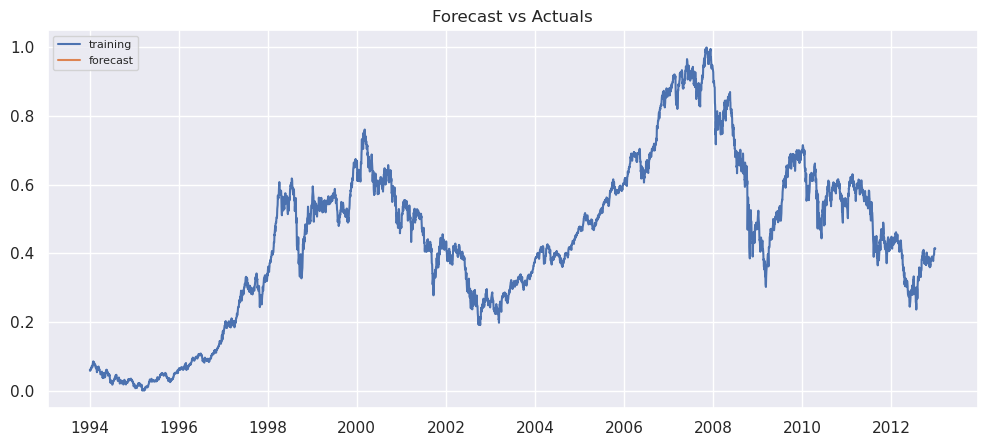

In [757]:
# Build Model
# model = ARIMA(train, order=(3,2,1))  
model = ARIMA(X_train['Adj Close'] , order=(1, 1, 1))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=X_test.index)


# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(X_train['Adj Close'], label='training')
#plt.plot(X_test['Adj Close'], label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()